# Background Removal (CIELUV Color Thresholding)
*By: Ian Chu Te*


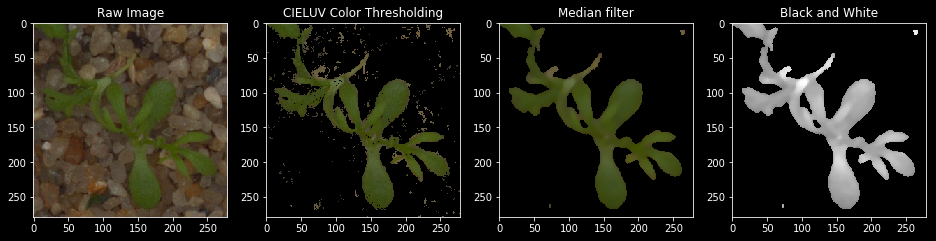


Background removal is easy to do because all the seedlings in the photos are greenish in color. What is important is to find a distance metric that is able to find similar colors to a given reference point. In this notebook, a distance metric in the [CIELUV color space](https://en.wikipedia.org/wiki/CIELUV) is demonstrated. Afterwards, a median filter is applied to remove artifacts. Finally, conversion to black and white shows an image that is well-prepared for a machine learning task.


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob

%matplotlib inline

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('dark_background')

In [47]:
def cieluv(img, target):
    # adapted from https://www.compuphase.com/cmetric.htm
    img = img.astype('int')
    aR, aG, aB = img[:,:,0], img[:,:,1], img[:,:,2]
    bR, bG, bB = target
    rmean = ((aR + bR) / 2.).astype('int')
    r2 = np.square(aR - bR)
    g2 = np.square(aG - bG)
    b2 = np.square(aB - bB)
    
    # final sqrt removed for speed; please square your thresholds accordingly
    result = (((512+rmean)*r2)>>8) + 4*g2 + (((767-rmean)*b2)>>8)
    
    return result

**Background Removal Logic**

    img_filter = ((cieluv(img, (71, 86, 38)) > 1600) 
    & (cieluv(img, (65, 79, 19)) > 1600) 
    & (cieluv(img, (95, 106, 56)) > 1600) 
    & (cieluv(img, (56, 63, 43)) > 500))

The three-element tuples are reference colors in RGB. 

1600 and 500 are distance thresholds.

So, for `cieluv(img, (71, 86, 38)) > 1600)` I am saying:

1. Take img and compare it with "leafy green" (71, 86, 38) 

2. Afterwards, give me all the pixels with CIELUV distances greater than 1600 
(in other words, take all *non-leafy green pixels*)

I am doing the same thing with the rest of the 3 lines but with different colors

 `(cieluv(img, (65, 79, 19)) > 1600)`   -- different shade of leaf green

 `(cieluv(img, (95, 106, 56)) > 1600)`   -- stem color

 `(cieluv(img, (56, 63, 43)) > 500)`   -- dark leaf green

Afterwards, I do a *logical AND (&)* on all of them to get only pixels which are *completely* rubbish
 (that is, pixels which have not passed any of the color tests for leaf/stems)

And then I finally remove the rubbish/background using the following line:

    img[img_filter] = 0

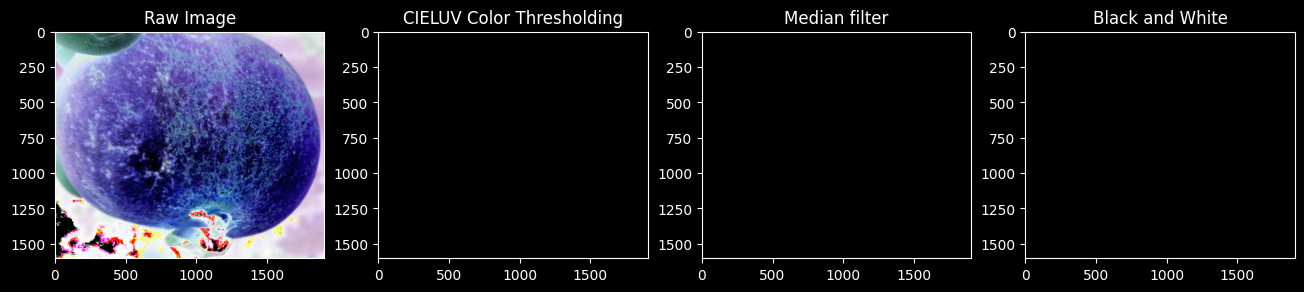

In [48]:
def process_image(f, plot=True):
    img = plt.imread(f)
    img = np.round(img * 255).astype('ubyte')[:,:,:3]
    if plot:
        plt.figure(1)
        plt.subplot(141)
        plt.imshow(img)
        plt.title('Raw Image')
    # Thiết lập ngưỡng ban đầu
    threshold1 = 1600
    threshold2 = 1600
    threshold3 = 1600
    threshold4 = 500
    # Vòng lặp để điều chỉnh ngưỡng
    for _ in range(10):  # Lặp 10 lần
        img_filter = (
            (cieluv(img, (300, 300, 80)) > threshold1)
            & (cieluv(img, (300, 300, 80)) > threshold2)
            & (cieluv(img, (300, 300, 80)) > threshold3)
            & (cieluv(img, (300, 300, 80)) > threshold4)
        )

        # Tăng ngưỡng lên 10 đơn vị cho mỗi lần lặp
        threshold1 += 10
        threshold2 += 10
        threshold3 += 10
        threshold4 += 10
    img[img_filter] = 0
    
    if plot:
        plt.subplot(142)
        plt.imshow(img)
        plt.title('CIELUV Color Thresholding')
    
    img = cv2.medianBlur(img, 9)
    
    if plot:
        plt.subplot(143)
        plt.imshow(img)
        plt.title('Median filter')
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype('uint8')
    
    if plot:
        plt.subplot(144)
        plt.imshow(img)
        plt.title('Black and White')
    return img
i = process_image('Guava Dataset/Scab/Scab(1).jpg')

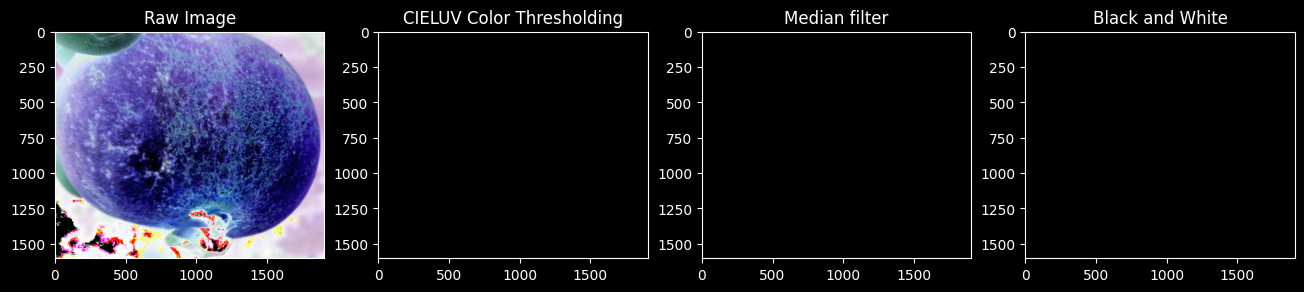

In [49]:
i = process_image('Guava Dataset/Scab/Scab(1).jpg')